# About This Analysis
Goal: What values about the episode, manga, or guest correlate with a high number of streams on *Spotify* within the first four weeks (28 days) of an episode coming out

### Terms:
- Starts (Number of times an episode was played for at least 0 seconds)
- Streams (Number of times an episode was played for at least 60 seconds)
- Listeners (Number of unique listeners based on starts)
- Main (A normal episode of Shonen Flop which fully covers a manga with a guest)
- Chibi (A half-length first impressions episode)

### Notes:
- Chainsaw Minute episodes were not considered
- Specials (floppies, best of year rerun, relooks, ranking) were omitted which can lead to gaps in episode numbers
- Tista now has an official translation but it came out after the relevant release period so it is still flagged as not having one
- Data collection started Sep 2022 as before that the podcast was promoted by Mother's Basement which led to an extremely high bump in listenership
- All main episodes have guests and have a Chibi episode which covers one chapter of the series that airs a week beforehand
- A series will only be listed if both the Chibi and Main episode both have 28 days of release time

### Shonen Flop
Shonen Flop is a weekly manga review podcast that looks at unsuccessful manga to determine if they were worthy of cancellation or not. Episodes come out every Monday at 6pm EST and can be found on Spotify, iTunes, YouTube or wherever else you get your podcasts. Our website is shonenflop.com

In [1]:
import pygs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import os
pd.options.mode.chained_assignment = None #don't show warning flags
%matplotlib inline

from IPython.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:97% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(16.7,4.27)})

def get_flop_gsheet_data(tab_name):
    shonen_flop_data_url = '12D55dJCZSnfjtDgjwc_BCuRSSXdCWkw0rUWjJYLQMNw'
    flop_import = pygs.read_google_sheet(spreadsheetId = shonen_flop_data_url, sheet_name = tab_name)
    return flop_import

## SCHEDULE FUNCTIONS
def import_schedule_column_cleanup():
    schedule_import.drop(['Record'],axis=1, inplace=True)
    schedule_import.rename({'#':'episode_number', 'Type':'type', 'Manga':'manga', 
                            'Guest':'guest_name', 'Release':'episode_release_date', 'Four_Weeks':'data_collection_cutoff_date', }, axis = 1, inplace=True)

def import_schedule_datatype_cleanup():
    schedule_import['episode_number'] = schedule_import['episode_number'].apply(pd.to_numeric, errors='coerce')
    schedule_import['episode_release_date'] = pd.to_datetime(schedule_import['episode_release_date'], format='%m/%d/%Y')
    schedule_import['data_collection_cutoff_date'] = pd.to_datetime(schedule_import['data_collection_cutoff_date'], format='%m/%d/%Y')

def import_schedule_cleanup():
    import_schedule_column_cleanup()
    import_schedule_datatype_cleanup()

## PERFORMANCE FUNCTIONS
def get_performance_data():
    current_path = os.getcwd()
    performance_sum = pd.DataFrame()
    directory = 'performance_data'
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            #print(f)
            performance_csv = pd.read_csv(f)
            performance_csv['range_key'] = f[:-4] #drop ".csv"
            performance_csv = performance_csv.groupby(['range_key']).agg({'starts':'sum','streams':'sum','listeners':'sum'}).reset_index()
            performance_sum = pd.concat([performance_sum,performance_csv])
    return performance_sum

def create_performance_date_fields(string_start = "episode-", string_end = "_to_"):
    performance_sum["episode_release_date"] = performance_sum['range_key'].apply(lambda st: st[st.find(string_start)+len(string_start):st.find(string_end)])
    performance_sum['episode_release_date'] = pd.to_datetime(performance_sum['episode_release_date'], format='%Y-%m-%d')

    performance_sum["data_collection_cutoff_date"] = performance_sum['range_key'].apply(lambda st: st[st.find(string_end)+len(string_end):])
    performance_sum['data_collection_cutoff_date'] = pd.to_datetime(performance_sum['data_collection_cutoff_date'], format='%Y-%m-%d')

def rename_performance_fields():
    performance_sum.rename({'starts':'start_count', 'streams':'stream_count', 'listeners':'listener_count'}, axis = 1, inplace=True)
    
def performance_data_cleanup():
    create_performance_date_fields()
    rename_performance_fields()
    performance_sum.drop(['range_key'],axis=1, inplace=True)

## MERGED DATA FUNCTIONS
def apply_int_type():
    int_columns = ['audience_size_thousand','chapter_count','chibi_length_minute','main_length_minute', 'run_length_year', 'chapter_length_multiplier'] #run_length_year is a float
    episode_data[int_columns] = episode_data[int_columns].apply(pd.to_numeric, errors='coerce')
    
    episode_data['audience_size_thousand'] = episode_data['audience_size_thousand'].fillna(0).astype(int) #for some reason need to do this on it's own

def apply_bool_type():
    bool_columns = episode_data.columns.tolist()
    bool_columns = [column for column in bool_columns if "is_" in column]
    episode_data[bool_columns] = episode_data[bool_columns].replace({'TRUE': True, 'FALSE': False})
    
def apply_date_type():
    episode_data['manga_start_date'] = pd.to_datetime(episode_data['manga_start_date'], format='%m/%d/%Y')
    episode_data['manga_end_date'] = pd.to_datetime(episode_data['manga_end_date'], format='%m/%d/%Y')

def apply_data_type_change():
    apply_int_type()
    apply_bool_type()
    apply_date_type()
    
def create_calc_fields():
    episode_data['end_to_ep_release_diff_month'] = round(((episode_data.episode_release_date - episode_data.manga_end_date)/np.timedelta64(1, 'M')),2) #round to make the number more reasonable
    
    #since we don't have enough data to calculate buckets, we just use reasonable sizes
    #note this is unused due to bucket populations being too small
    episode_data['guest_size_bucket'] = np.where(episode_data['guest_name'] == 'N/A',     '0 N/A',
                                    np.where(episode_data['audience_size_thousand'] <=10, '1 Very small',
                                    np.where(episode_data['audience_size_thousand'] <=50, '2 Small',
                                    np.where(episode_data['audience_size_thousand'] <=100,'3 Medium',
                                    np.where(episode_data['audience_size_thousand'] <=500,'4 Large', 
                                                                                          '5 Very large')))))

    episode_data['start_stream_dropoff_perc'] = 1 - (round(episode_data['stream_count'] / episode_data['start_count'], 4))
    
    episode_data['is_creator_type_podcaster'] = episode_data['creator_type'] == 'Podcaster'
    episode_data['is_magazine_shonen_jump'] = episode_data['magazine'] == 'Weekly Shonen Jump'
    episode_data['is_action_genre'] = episode_data['genre_normalized'] == 'Action'
    
    episode_data['chapter_count_adjusted'] = episode_data['chapter_count'] * episode_data['chapter_length_multiplier'] #some series have much longer chapters so we account for this
    
    covered_quick_month_cutoff = 2
    episode_data['is_covered_quick'] = episode_data['end_to_ep_release_diff_month'] <= covered_quick_month_cutoff
    
    #square numbers to help with regression by accounting for how longer episodes can be detrimental
    episode_data['main_length_minute_squared'] = episode_data['main_length_minute'] ** 2
    episode_data['chibi_length_minute_squared'] = episode_data['chibi_length_minute'] ** 2
    
def create_category_int(): 
    episode_data['flop_rating_value'] = episode_data['flop_rating'].str[0].astype(int)
    episode_data['guest_size_bucket_value'] = episode_data['guest_size_bucket'].str[0].astype(int)

def drop_unneeded_columns(drop = True):
    drop_columns = ['data_collection_cutoff_date','genre_list', 'chapter_count', 'chapter_length_multiplier']
    if drop:
        episode_data.drop(columns = drop_columns, inplace = True)
    else:
        print("drop set to false; not dropping: {}".format(drop_columns))
        
## ANALYTICAL FUNCTIONS
def calculate_chibi_main_rate():
    episode_data_main_merge = pd.merge(episode_data_main, episode_data_chibi[['manga','stream_count']], on=['manga'], how='left') #need to create a new variable due to scoping
    episode_data_main_merge.rename({'stream_count_x':'stream_count', 'stream_count_y':'stream_count_chibi'}, axis = 1, inplace=True)
    episode_data_main_merge['chibi_vs_main_stream_perc'] = round(episode_data_main_merge['stream_count_chibi'] / episode_data_main_merge['stream_count'],4)
    return episode_data_main_merge

def calculate_mean(df):
    start_count_mean = int(round(df['start_count'].mean(),0))
    stream_count_mean = int(round(df['stream_count'].mean(),0))
    listener_count_mean = int(round(df['listener_count'].mean(),0))
    dropoff_perc_mean = round(df['start_stream_dropoff_perc'].mean(),4)
    
    print("  start_count mean: {}".format(start_count_mean))
    print("  stream_count mean: {}".format(stream_count_mean))
    print("  listener_count mean: {}".format(listener_count_mean))
    print("  dropoff_perc_mean: {}".format(dropoff_perc_mean))
    return start_count_mean, stream_count_mean, listener_count_mean, dropoff_perc_mean

def myfunc(x):
    return slope * x + intercept

def show_regression(x, y):
    mymodel = list(map(myfunc, x))
    print('r: {}\np: {}\nbeta: {}'.format(r,p,slope))
    plt.scatter(x, y)
    plt.plot(x, mymodel)
    plt.show()
    
def category_ratio(category, df):
    print(round(df[category].value_counts() / len(df),4))
    
## Unused but could be used for other analysis 
def crosstab(x, y, percent = False):
    if percent:
        crosstab = pd.crosstab(x, y, normalize='index')
    else:
        crosstab = pd.crosstab(x, y)
    return crosstab

def make_heatmap(tasks):
    plt.figure(figsize=(12,8))
    sns.heatmap(tasks, annot=True, cmap="YlGnBu")

### Regression Notes:
- If p value is .05 or greater it is likely not significant (what is the probability of the number you got the number is random)
- R-squared: percent of variance in model explained by the model (higher is better up to a point [at 1 your model is a problem])
  - R-squared < .15 is probably not accounting enough in the model
- Cross compare R-squared you find that really matter together and see how they play together
- Coef: size of impact (positive or negative) on the metric you are comparing for
  - Intercept: the average coef (the b in y = mx + b)

# Generate Data for Analysis

In [2]:
schedule_import = get_flop_gsheet_data('Schedule Import')
import_schedule_cleanup()

performance_sum = get_performance_data()
performance_data_cleanup()

episode_data = pd.merge(schedule_import, performance_sum, on=['episode_release_date', 'data_collection_cutoff_date'], how='left')

guest_info = get_flop_gsheet_data('Guest Information')
guest_info['audience_size_thousand'] = guest_info['audience_size_thousand'].apply(pd.to_numeric, errors='coerce')

episode_data = pd.merge(episode_data, guest_info, on=['guest_name'], how='left')

#verify no missing data for guests
#print(len(episode_data.loc[(episode_data['type'] == 'Main') & (episode_data['creator_type'].isnull())]))
#print(len(episode_data.loc[(episode_data['type'] == 'Chibi') & (~episode_data['creator_type'].isnull())]))

manga_info = get_flop_gsheet_data('Manga Information')
episode_data = pd.merge(episode_data, manga_info, on=['manga'], how='inner')
episode_data['creator_type'] = episode_data['creator_type'].fillna('N/A')

apply_data_type_change()
create_calc_fields()
create_category_int()
drop_unneeded_columns()

In [3]:
#split by regular and chibi to simplify analysis
episode_data_main = episode_data.loc[(episode_data['type'] == 'Main')]
episode_data_chibi = episode_data.loc[(episode_data['type'] == 'Chibi')]
episode_data_main = calculate_chibi_main_rate()
episode_data_main.head(5)

,episode_number,type,manga,guest_name,episode_release_date,start_count,stream_count,listener_count,creator_type,audience_size_thousand,genre_normalized,magazine,author,is_famous_author,manga_start_date,manga_end_date,run_length_year,is_official_translation,flop_rating,chibi_length_minute,main_length_minute,end_to_ep_release_diff_month,guest_size_bucket,start_stream_dropoff_perc,is_creator_type_podcaster,is_magazine_shonen_jump,is_action_genre,chapter_count_adjusted,is_covered_quick,main_length_minute_squared,chibi_length_minute_squared,flop_rating_value,guest_size_bucket_value,stream_count_chibi,chibi_vs_main_stream_perc
0,60.0,Main,Doron Dororon,Meghan (Volume One),2022-09-19,482,390,345,Podcaster,23,Action,Weekly Shonen Jump,Gen Osuka,False,2021-12-13,2022-08-29,0.7,True,2 Flop,31,63,0.69,2 Small,0.1909,True,True,True,36,True,3969,961,2,2,215,0.5513
1,61.0,Main,Earthchild,Laura (The Piece Meal Podcast),2022-10-03,467,388,339,Podcaster,1,Romance,Weekly Shonen Jump,Hideo Shinkai,False,2022-03-07,2022-09-19,0.5,True,3 Certified Flop,23,51,0.46,1 Very small,0.1692,True,True,False,27,True,2601,529,3,1,199,0.5129
2,62.0,Main,Hi-Fi Cluster,Courtney (The Strictly Series),2022-10-17,378,295,265,Podcaster,5,Action,Weekly Shonen Jump,Ippei Goto,False,2014-09-29,2015-02-09,0.4,True,3 Certified Flop,26,56,92.22,1 Very small,0.2196,True,True,True,18,False,3136,676,3,1,174,0.5898
3,63.0,Main,Sakuratetsu Taiwahen,Red Bard,2022-10-31,327,278,241,YouTuber,250,Action,Weekly Shonen Jump,Ryu Fujisaki,True,2002-01-01,2002-05-06,0.3,False,2 Flop,20,52,245.85,4 Large,0.1498,False,True,True,14,False,2704,400,2,4,161,0.5791
4,64.0,Main,Super Smartphone,Neysha,2022-11-14,512,408,351,Podcaster,5,Adventure,Weekly Shonen Jump,"Hiroki Tomisawa, Kentaro Hidano",False,2022-05-23,2022-10-17,0.4,True,3 Certified Flop,21,62,0.92,1 Very small,0.2031,True,True,False,24,True,3844,441,3,1,196,0.4804


# Analysis
Note: line graph was used as episodes are listed in release order (names shown instead of dates for simplification of analysis)

Note: For this analysis we're going to focus on stream_count as the main metric of focus as we want people to listen to the show (unfortunately listeners are based on starts and not streams)

## Main vs Chibi

Can you predict a Main episodes' performance based on the Chibi

In [4]:
print("Main:")
main_start_mean, main_stream_mean, main_listener_mean, main_dropoff_perc_mean = calculate_mean(episode_data_main)
print("")
print("Chibi:")
chibi_start_mean, chibi_stream_mean, chibi_listener_mean, chibi_dropoff_perc_mean = calculate_mean(episode_data_chibi)

episode_data_main['chibi_vs_main_stream_perc'].describe()

Main:
  start_count mean: 558
  stream_count mean: 409
  listener_count mean: 386
  dropoff_perc_mean: 0.2537

Chibi:
  start_count mean: 318
  stream_count mean: 216
  listener_count mean: 252
  dropoff_perc_mean: 0.2988


count    26.000000
mean      0.538212
std       0.080895
min       0.388100
25%       0.483375
50%       0.551200
75%       0.577800
max       0.697500
Name: chibi_vs_main_stream_perc, dtype: float64

- We can see that Main episodes overwhelmingly do better than Chibis which is not a surprise
- A higher % of users don't last a full minute on Chibis which may be a sign they don't find the episode topic as interesting

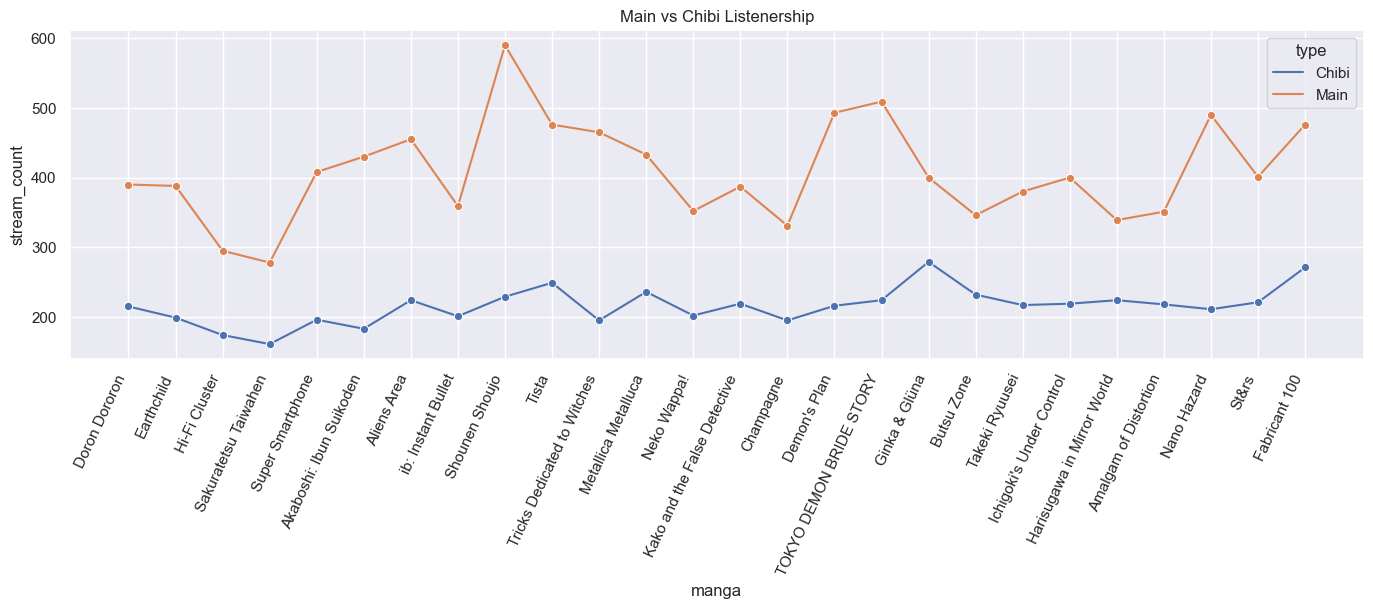

In [5]:
sns.lineplot(x='manga', y='stream_count', markers = True, hue = 'type', data=episode_data, marker = 'o').set(title = "Main vs Chibi Listenership")
plt.xticks(rotation=65, horizontalalignment='right'); #semicolon surpresses function returning tick values

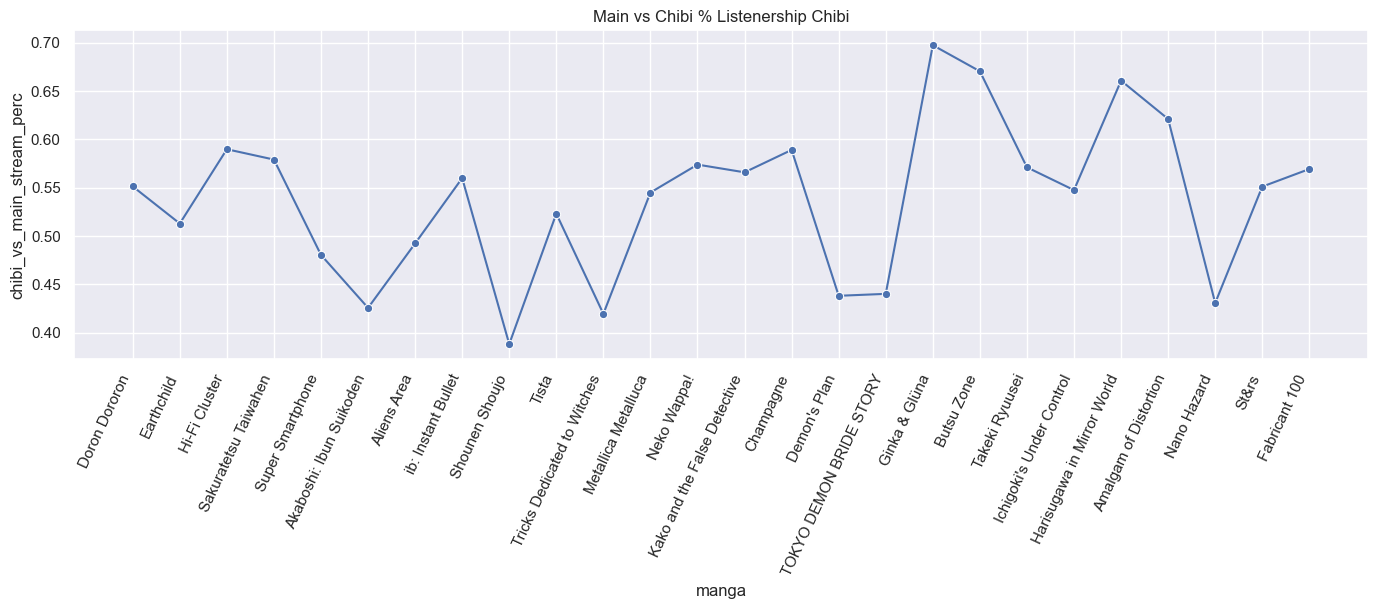

In [6]:
sns.lineplot(x='manga', y='chibi_vs_main_stream_perc', markers = True, data=episode_data_main, marker = 'o').set(title = "Main vs Chibi % Listenership Chibi")
plt.xticks(rotation=65, horizontalalignment='right'); #semicolon surpresses function returning tick values

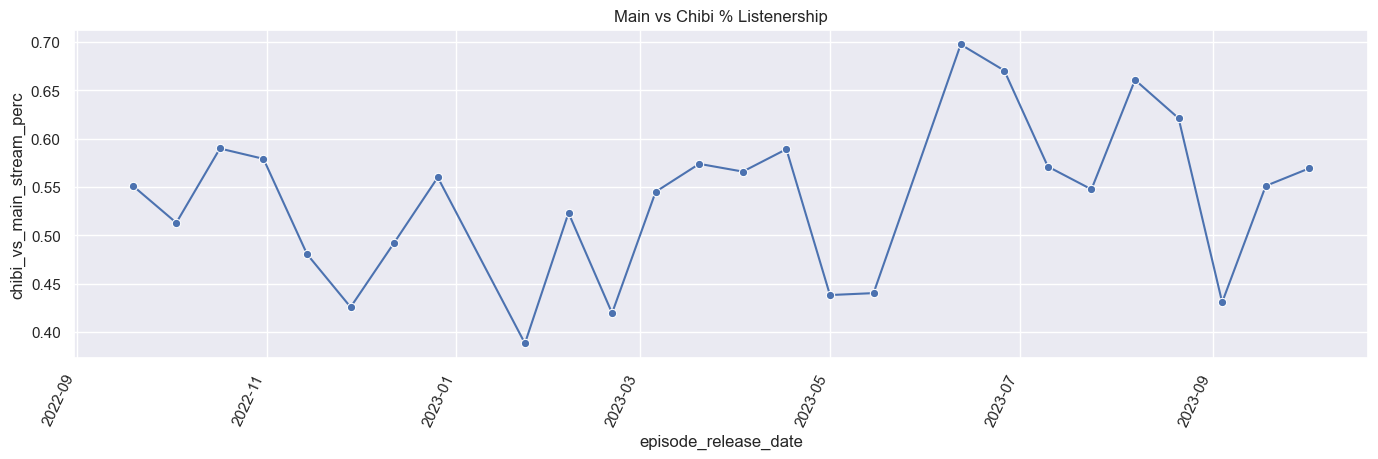

In [7]:
sns.lineplot(x='episode_release_date', y='chibi_vs_main_stream_perc', markers = True, data=episode_data_main, marker = 'o').set(title = "Main vs Chibi % Listenership")
plt.xticks(rotation=65, horizontalalignment='right'); #semicolon surpresses function returning tick values

r: 0.44461695749452523
p: 0.022859709197888795
beta: 1.2194273179450605


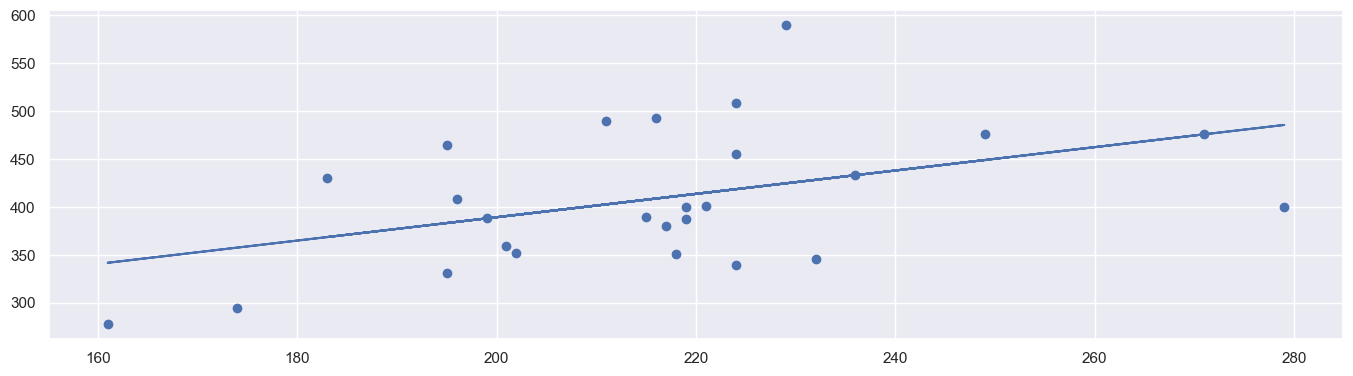

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     5.913
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0229
Time:                        09:03:50   Log-Likelihood:                -144.57
No. Observations:                  26   AIC:                             293.1
Df Residuals:                      24   BIC:                             295.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            145.4236    108

In [8]:
x = episode_data_main['stream_count_chibi']
y = episode_data_main['stream_count']
slope, intercept, r, p, std_err = stats.linregress(x, y)
show_regression(x, y)

reg = smf.ols('stream_count ~ stream_count_chibi',data=episode_data_main).fit()
print(reg.summary())

### Overall thoughts:
- Based on the line graph and regression we see that chibi performance is a somewhat weak indicator of main episode performance
- This could be a sign that the manga itself has some influence on episode popularity
- It's interesting a chibi on average does about 50% of the number of a main episode

## Influence of Guest on Episode Popularity
Does the guest's medium of choice or their fanbase size related to popular episodes

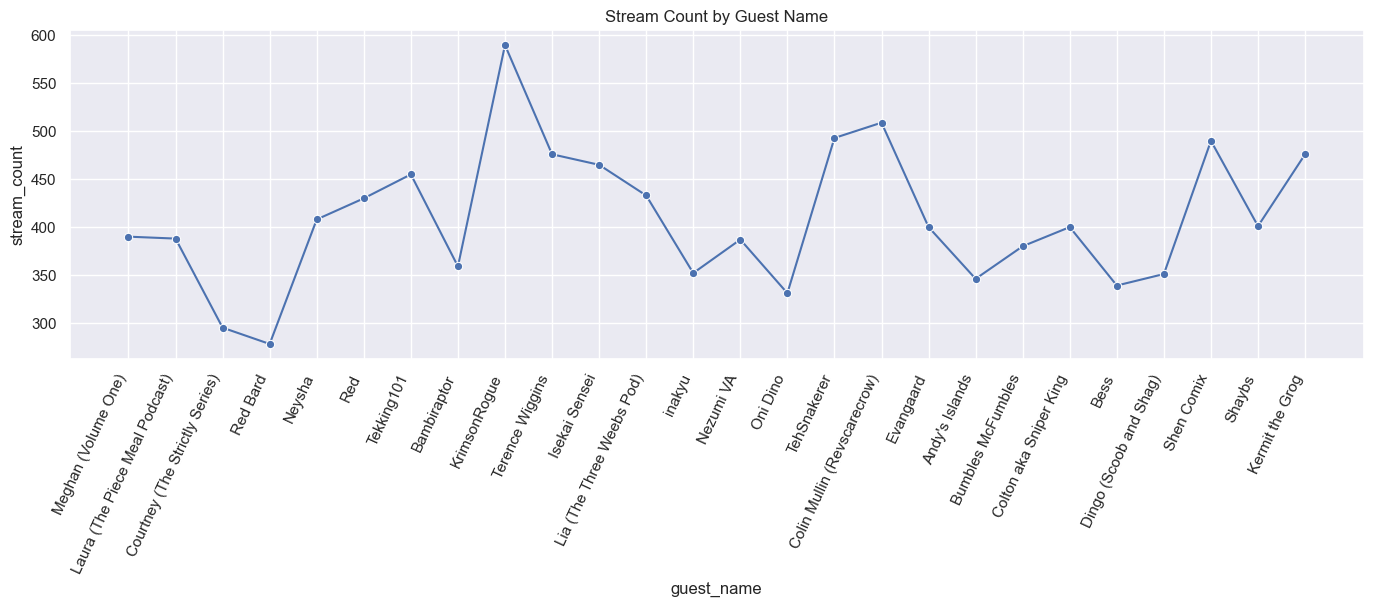

In [9]:
sns.lineplot(x='guest_name', y='stream_count', markers = True, data=episode_data_main, marker = 'o').set(title = "Stream Count by Guest Name")
plt.xticks(rotation=65, horizontalalignment='right'); #semicolon surpresses function returning tick values

### Guest Category

In [10]:
print('Category breakdown - population')
episode_data_main.groupby('creator_type').describe()['stream_count']['count']

Category breakdown - population


creator_type
Cartoonist       2.0
Podcaster       10.0
Streamer         1.0
Topic Expert     2.0
YouTuber        11.0
Name: count, dtype: float64

In [11]:
print("Category breakdown - percent of population")
category_ratio('creator_type', episode_data_main)

Category breakdown - percent of population
YouTuber        0.4231
Podcaster       0.3846
Topic Expert    0.0769
Cartoonist      0.0769
Streamer        0.0385
Name: creator_type, dtype: float64


- Due to the lack of sufficient population in most categories, we're going to see if being a podcaster helps with listenership.
- YouTuber's have an inherent bias in that they may bring attention to the YouTube posting of the episode which wasn't data collected for this experiment

In [12]:
reg = smf.ols('stream_count ~ is_creator_type_podcaster',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                 0.0006481
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.980
Time:                        09:03:51   Log-Likelihood:                -147.43
No. Observations:                  26   AIC:                             298.9
Df Residuals:                      24   BIC:                             301.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

The P-value is too high to view this as significant

### Guest Popularity

In [13]:
episode_data_main.groupby('guest_size_bucket').describe()['stream_count'][['count','mean']].reset_index()

,guest_size_bucket,count,mean
0,1 Very small,13.0,394.461538
1,2 Small,5.0,398.200000
2,3 Medium,1.0,387.000000
3,4 Large,4.0,435.250000
4,5 Very large,3.0,458.333333


- At a quick glance it looks like guest size doesn't matter too heavily unless the guest is large or very large (>500k)
- We also see that bucket sizes don't have enough values for proper regression so we stick to audience_size_thousand

In [14]:
reg = smf.ols('stream_count ~ audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.612
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.216
Time:                        09:03:51   Log-Likelihood:                -146.59
No. Observations:                  26   AIC:                             297.2
Df Residuals:                      24   BIC:                             299.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                401

The P-value is too high to view this as significant

### Overall thoughts:
- While you would think a guest with a larger fandom would massively increase the listenership, this doesn't appear to be the case; though it doesn't hurt to have a larger guest as they may have long-tail benefits like adding name recognition which wouldn't be captured in this data
- Having a podcaster on as a guest doesn't really matter

## Influence of Manga on Episode Popularity

Are there any factors about the manga itself that lead to more popular episodes

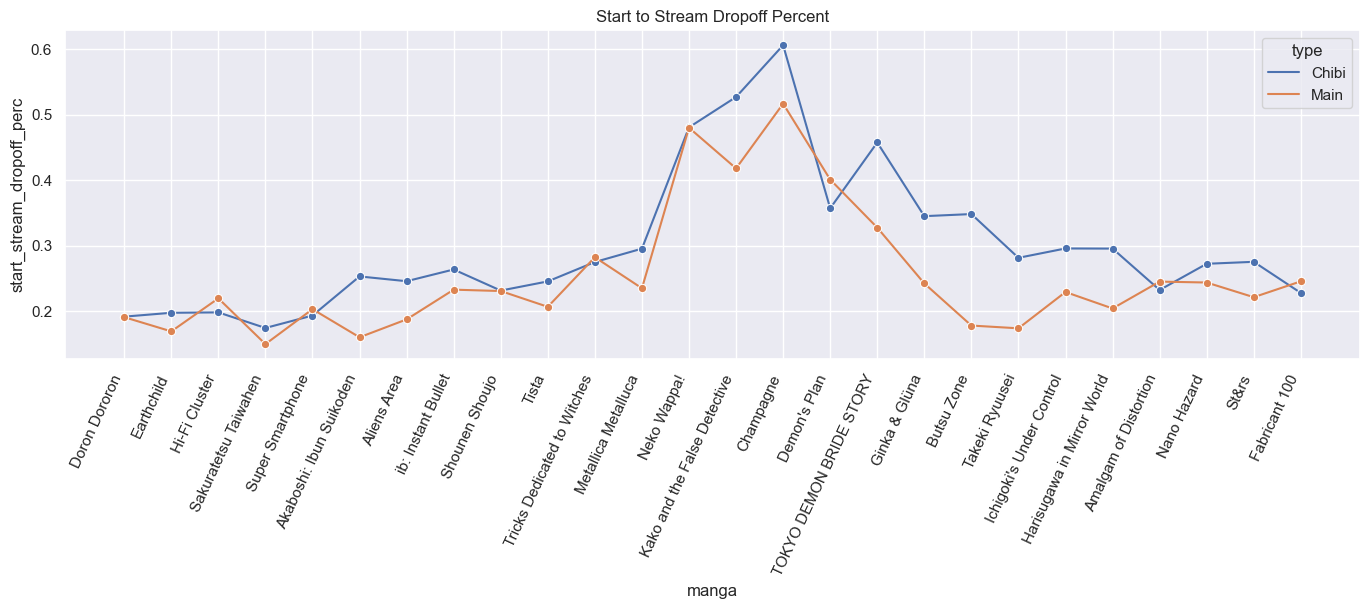

In [15]:
sns.lineplot(x='manga', y='start_stream_dropoff_perc', markers = True, hue = 'type', data=episode_data, marker = 'o').set(title = "Start to Stream Dropoff Percent")
plt.xticks(rotation=65, horizontalalignment='right'); #semicolon surpresses function returning tick values

- It's interesting to see that the drop off percent is closely related between the main and chibi, it is possible users may be dropping off episodes due to the topic
- This could be hinted by 'Kako and the False Detective' and 'Champagne' both having high drop off rates and are both non-shonen Manga
- However, Demon's Plan Is a more action typical shonen so we'll have to really dive in

In [16]:
episode_data_main.groupby('magazine').describe()['stream_count']['count']

magazine
Dengeki Maoh           1.0
Grand Jump             1.0
Jump SQ                2.0
Shounen Magazine       1.0
Shōnen Jump+           1.0
Weekly Shonen Jump    19.0
Young Jump             1.0
Name: count, dtype: float64

In [17]:
episode_data_main.groupby('genre_normalized').describe()['stream_count']['count']

genre_normalized
Action           10.0
Adventure         3.0
Comedy            4.0
Drama             1.0
Fantasy           1.0
Mystery           2.0
Romance           1.0
Sci-Fi            3.0
Slice of Life     1.0
Name: count, dtype: float64

We don't have enough variety in either magazine or genre, so we'll simply look at if they are Shonen Jump and if they are an action series

In [18]:
reg = smf.ols('stream_count ~ is_magazine_shonen_jump + is_action_genre',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.253
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.304
Time:                        09:03:52   Log-Likelihood:                -146.09
No. Observations:                  26   AIC:                             298.2
Df Residuals:                      23   BIC:                             302.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Overall, it looks like being in Weekly Shonen Jump and being an action series don't really matter, unfortunately we don't have enough data to determine if any other genres or magazines could have an impact

In [19]:
reg = smf.ols('stream_count ~ is_famous_author',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                   0.06357
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.803
Time:                        09:03:52   Log-Likelihood:                -147.40
No. Observations:                  26   AIC:                             298.8
Df Residuals:                      24   BIC:                             301.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Covering a manga by a famous author doesn't seem to make much difference either (an author is considered famous if the author has a Wikipedia page or otherwise is historically important to the industry such as having a long-running series)

### Manga Accessibility

In [20]:
reg = smf.ols('stream_count ~ is_official_translation + chapter_count_adjusted',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.5757
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.570
Time:                        09:03:52   Log-Likelihood:                -146.80
No. Observations:                  26   AIC:                             299.6
Df Residuals:                      23   BIC:                             303.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

<Axes: xlabel='stream_count', ylabel='chapter_count_adjusted'>

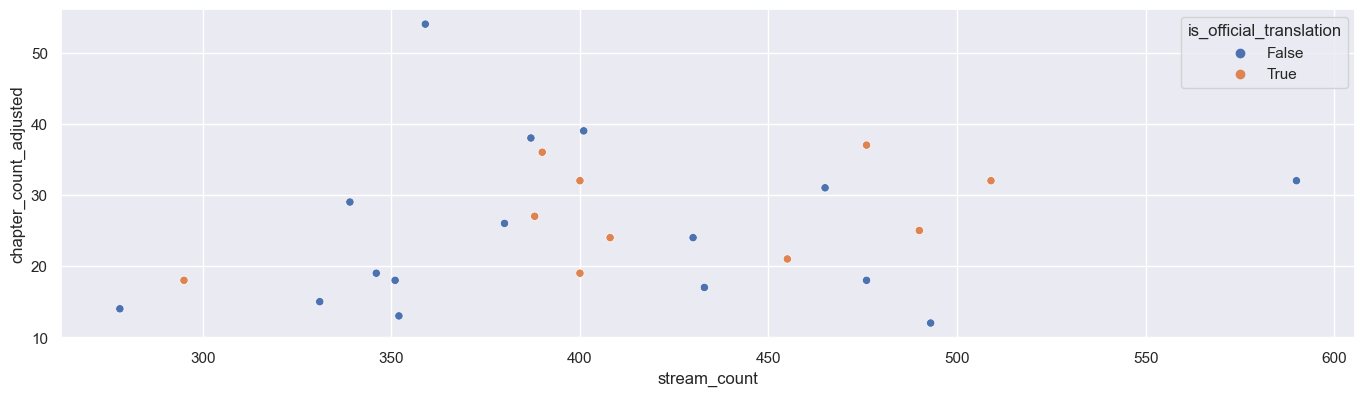

In [21]:
sns.scatterplot(x="stream_count", y="chapter_count_adjusted", hue="is_official_translation", data=episode_data_main)

<Axes: xlabel='stream_count', ylabel='run_length_year'>

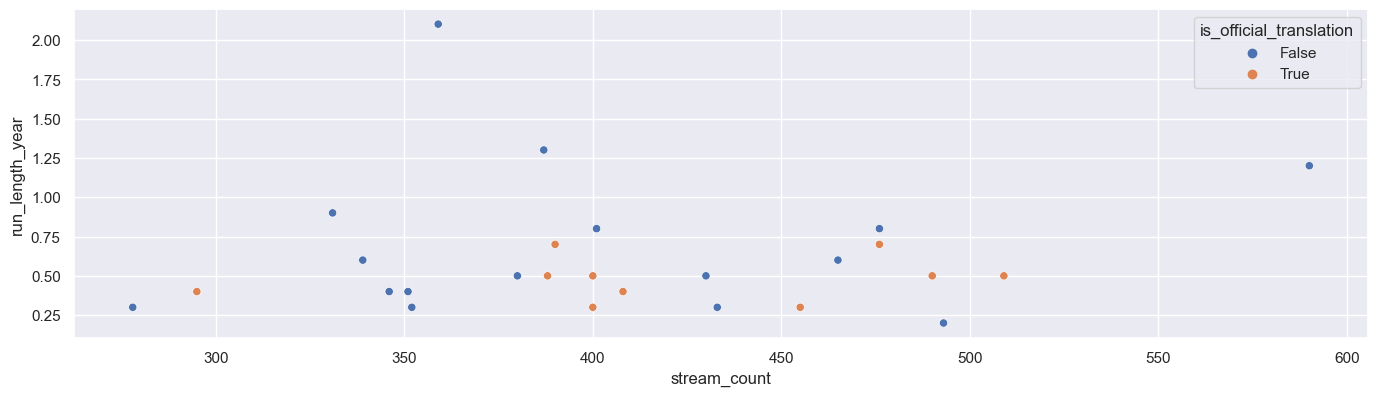

In [22]:
sns.scatterplot(x="stream_count", y="run_length_year", hue="is_official_translation", data=episode_data_main)

<Axes: xlabel='chapter_count_adjusted', ylabel='Count'>

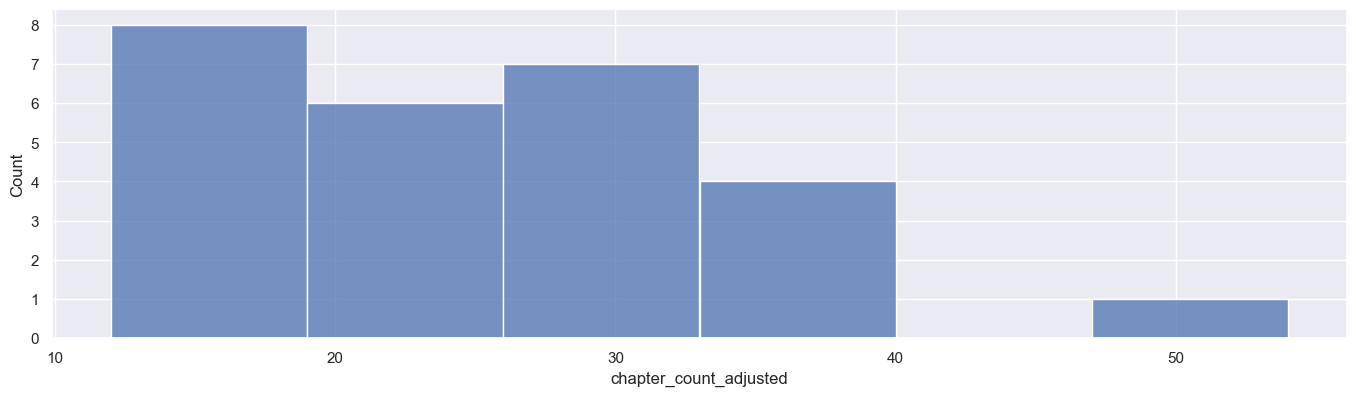

In [23]:
sns.histplot(data=episode_data_main, x="chapter_count_adjusted")

<Axes: xlabel='chapter_count_adjusted', ylabel='Count'>

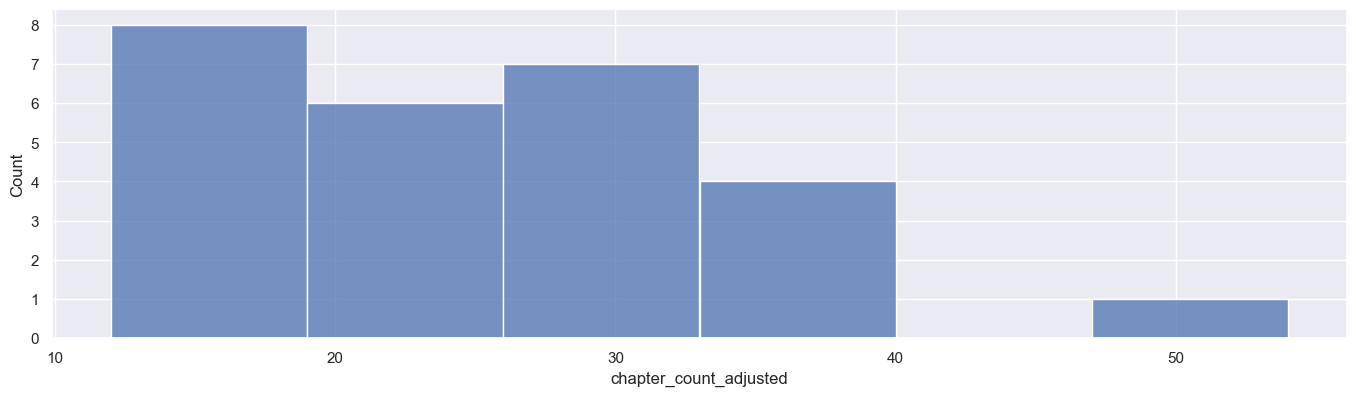

In [24]:
sns.histplot(data=episode_data_main, x="chapter_count_adjusted")

- We want to see if users prefer to listen to episodes they can more easily read, which is reflected by having an official translation or a shorter chapter count
- Somewhat surprising, statistically speaking it does not look like official translation and length influence episode popularity
- This is backed up visually it also doesn't look like there's an extremely high correlation, even if instead of chapter length you go with literal run time of the series
- The distribution of chapter count is somewhat right-tailed, though we have a bias of around 30ish chapters as our general cutoff is 35 chapters

### Overall thoughts:
- It does not like any factors relating to the manga itself strongly correlate with why a series does well even things like having a shorter length, a famous author, or an official translation

## Influence of the Episode itself on Episode Popularity
Do factors about the episodes production or release affect popularity?

### Time Between Cancelation and Coverage

A long-standing theory has been if recording episodes matters as soon as a series is cancelled (within two months). The thought is we can capitalize on the (small) fanbase before it dissipates

In [25]:
episode_data_main.groupby('is_covered_quick').describe()['stream_count'][['count','mean']].reset_index()

,is_covered_quick,count,mean
0,False,20.0,399.800000
1,True,6.0,437.666667


In [26]:
reg = smf.ols('stream_count ~ is_covered_quick',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.306
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.264
Time:                        09:03:53   Log-Likelihood:                -146.75
No. Observations:                  26   AIC:                             297.5
Df Residuals:                      24   BIC:                             300.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

- While we see about a 9% difference between is_covered means, the actual data doesn't show there's a statistical relationship
- As such, it looks like there is no inherent advantage to covering a series as soon as possible

### Episode Length

A common piece of advice in podcasting is to keep episodes around 50-60 minutes, which we pretty well stick to. The thought is this aligns well with commute times for people (so if you have a 30 minute commute you can listen to the entire thing there and back)

Note: we square the episode length to normalize the dataset as we want to see if too short or too long episodes both have negative attributes.

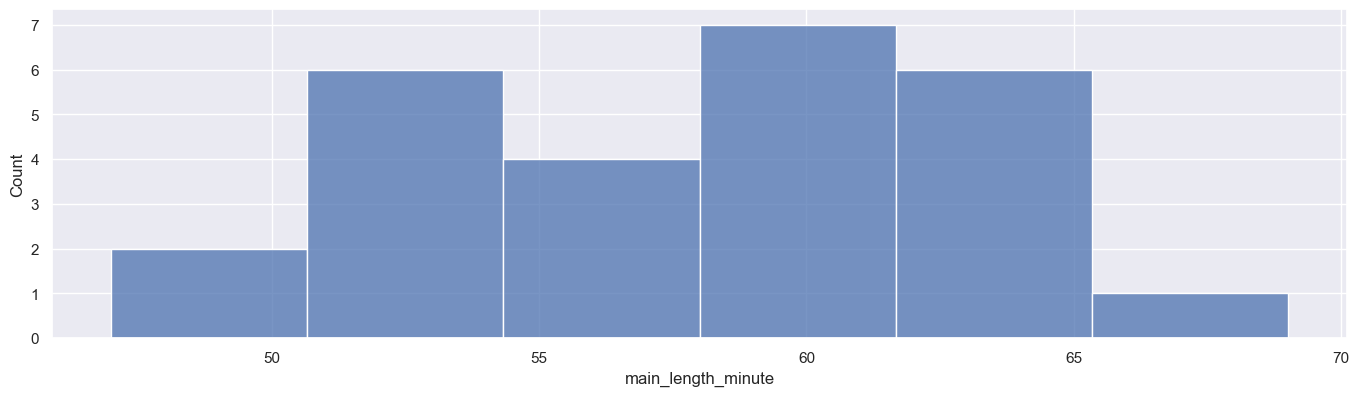

In [27]:
sns.histplot(data=episode_data_main, x="main_length_minute")
episode_length_mean = round(episode_data_main['main_length_minute'].mean(),0)

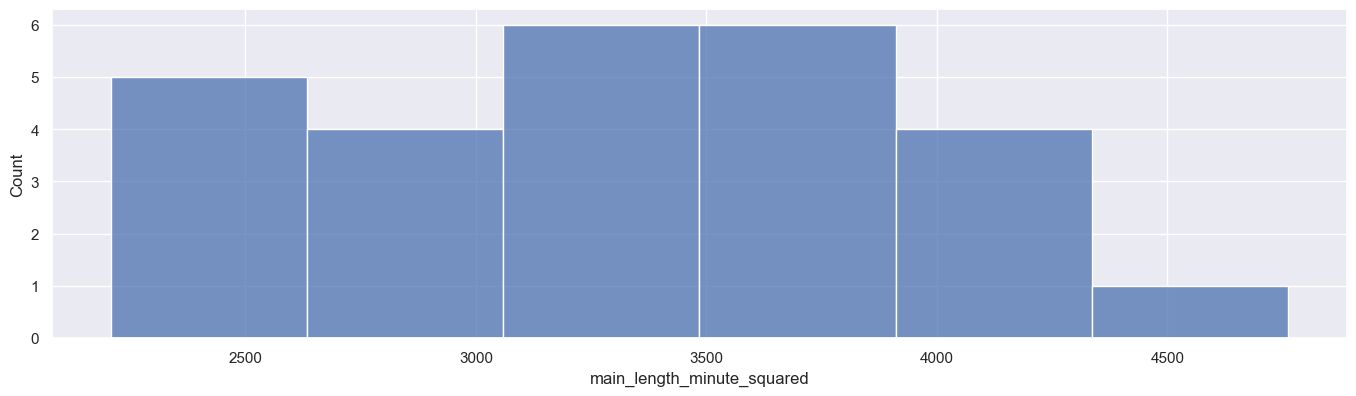

In [28]:
sns.histplot(data=episode_data_main, x="main_length_minute_squared")
episode_length_mean = round(episode_data_main['main_length_minute'].mean(),0)

We can see this helps normalize the data by squaring it

r: 0.4326040518802849
p: 0.027292950892653833
beta: 0.05023926200899438


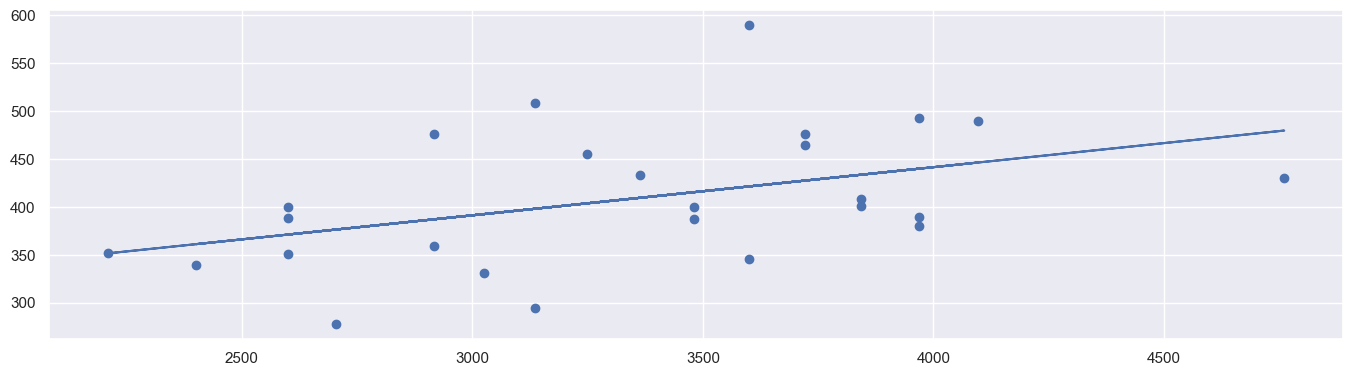

In [29]:
x = episode_data_main['main_length_minute_squared']
y = episode_data_main['stream_count']
slope, intercept, r, p, std_err = stats.linregress(x, y)
show_regression(x, y)

In [30]:
reg = smf.ols('stream_count ~ main_length_minute_squared',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5.526
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0273
Time:                        09:03:53   Log-Likelihood:                -144.74
No. Observations:                  26   AIC:                             293.5
Df Residuals:                      24   BIC:                             296.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

r: 0.44029107075365564
p: 0.024383212621268132
beta: 5.8655023694158945


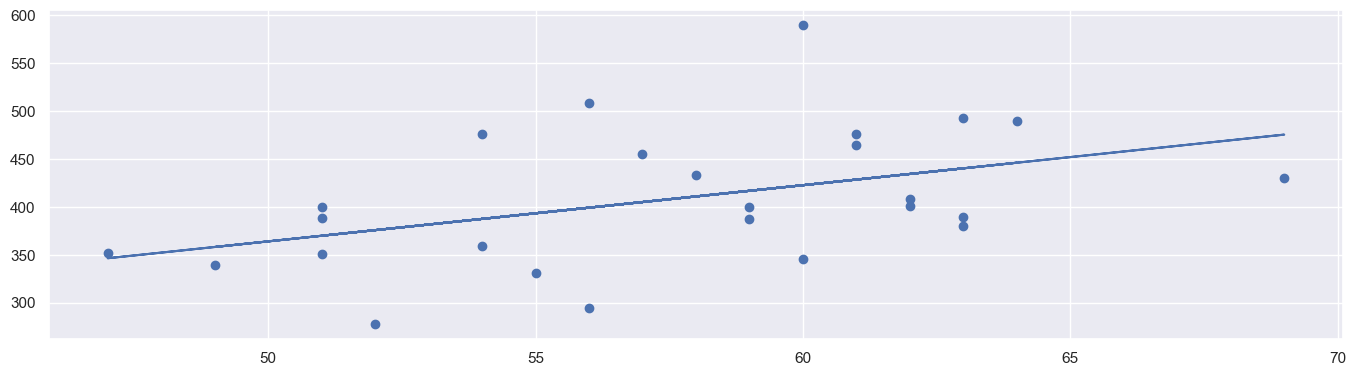

In [31]:
x = episode_data_main['main_length_minute']
y = episode_data_main['stream_count']
slope, intercept, r, p, std_err = stats.linregress(x, y)
show_regression(x, y)

In [32]:
reg = smf.ols('stream_count ~ main_length_minute',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     5.771
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0244
Time:                        09:03:53   Log-Likelihood:                -144.63
No. Observations:                  26   AIC:                             293.3
Df Residuals:                      24   BIC:                             295.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             70.8209    141

r: -0.22193125875443875
p: 0.27587328000172034
beta: -0.003996416591235821


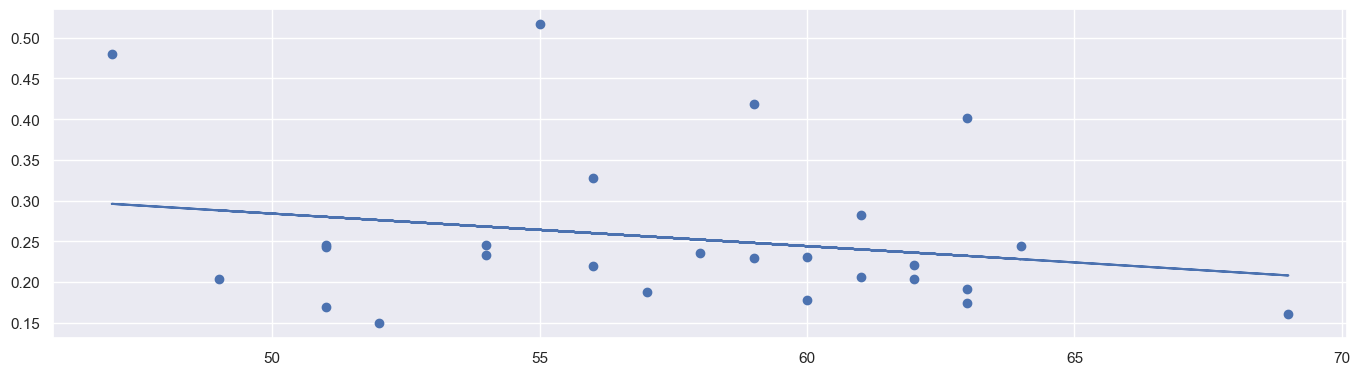

In [33]:
x = episode_data_main['main_length_minute']
y = episode_data_main['start_stream_dropoff_perc']
slope, intercept, r, p, std_err = stats.linregress(x, y)
show_regression(x, y)

- It looks like shorter episodes seem to not perform as well and we see improvement around the 60-minute mark with some minor dropoff if it goes past that
- Based on the coef we gain about 6 streams for every minute of length increase, but as noted there are dimishing and possibly negative returns beyond 60~ minutes
- While it looks like drop rates decrease on longer episodes, the P value is too high to rely on this

### Manga Review Score

Does the quality of the series matter? Shonen Flop ranks series as Not a Flop (1), Flop (2) or Certified Flop (3). A "Flop" could be considered "bad" while a "Certified Flop" could be described as "atrocious"

While this is objective, it does give a general idea if listeners are more interested in reviews of series of a specific critical quality

In [34]:
episode_data_main.groupby('flop_rating').describe().reset_index()['episode_number']['count']

0     3.0
1     9.0
2    14.0
Name: count, dtype: float64

<Axes: xlabel='stream_count', ylabel='Count'>

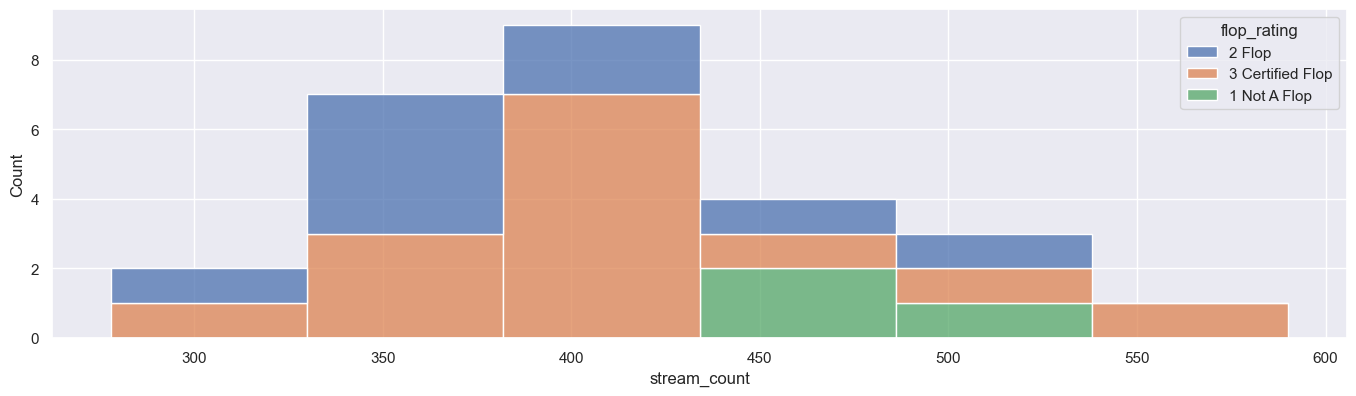

In [35]:
sns.histplot(data=episode_data_main, x="stream_count", hue='flop_rating', multiple="stack")

In [36]:
reg = smf.ols('stream_count ~ flop_rating_value',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.5126
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.481
Time:                        09:03:54   Log-Likelihood:                -147.16
No. Observations:                  26   AIC:                             298.3
Df Residuals:                      24   BIC:                             300.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           444.2430     51.84

In [37]:
reg = smf.ols('stream_count ~ flop_rating',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.116
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.143
Time:                        09:03:54   Log-Likelihood:                -145.24
No. Observations:                  26   AIC:                             296.5
Df Residuals:                      23   BIC:                             300.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

It looks like a floped series just barley may have a negative impact (based on the coef) on how well a series performs

### Overall thoughts:
- The majority of series covered are....not very good which is expected given good series tend to not be cancelled

## Multi Factors
We want to see if any regression influence is being downplayed so let's see if combining different factors from the three major categories (guest, manga, episode) reveal anything

Note: The vast majority did not show any influence, they have been listed in a section after the conclusion

In [45]:
reg = smf.ols('stream_count ~ is_famous_author + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.990
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.159
Time:                        09:03:54   Log-Likelihood:                -145.36
No. Observations:                  26   AIC:                             296.7
Df Residuals:                      23   BIC:                             300.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does being famous help if they're famous for being in Shonen Jump

Outcome: Published in WSJ gains some significance if you control for the fame of the author. Essentially you may lose streams if covering a series in Shonen Jump by a famous author

In [54]:
reg = smf.ols('stream_count ~ is_covered_quick + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     2.971
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0712
Time:                        09:03:54   Log-Likelihood:                -144.45
No. Observations:                  26   AIC:                             294.9
Df Residuals:                      23   BIC:                             298.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does a series being covered quickly matter if it was in jump

Outcome: It appears to have a negative effect if a recently axed series was in jump however it's brushing up against a unusable P value

In [66]:
reg = smf.ols('stream_count ~ main_length_minute_squared + is_covered_quick',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     3.825
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0368
Time:                        09:04:10   Log-Likelihood:                -143.70
No. Observations:                  26   AIC:                             293.4
Df Residuals:                      23   BIC:                             297.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Idea: We saw a strong coef for is_covered_quick and wanted to see if it impacts main_length_minute_squared which is the highest impact one

Outcome: Recency may have some impact, though it appears to be unrelated to episode length

In [67]:
reg = smf.ols('stream_count ~ main_length_minute_squared + is_covered_quick + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.048
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0196
Time:                        09:04:12   Log-Likelihood:                -141.72
No. Observations:                  26   AIC:                             291.4
Df Residuals:                      22   BIC:                             296.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: We saw a strong coef for is_covered_quick and wanted to see if it impacts main_length_minute_squared which is the highest impact one

Outcome: These three seem to have connection to eachother. It appears we gain listeners for recentely axed series, but lose them for being in WSJ.

## Conclusion
- Overall, it's hard to predict how well an episode will do. Things you would think would have a notable impact such as guest popularity, fame of the writer, or official translation do not seem to be statistically significant
- The only thing that possibly could have a notable correlation with success is episode length where being around the 60-minute mark does better than being under or drastically over. This held true when trying to see if there's any masking via multi-regression analysis
- There may be a minor positive relationship for recently cancelled series that are NOT in Weekly Shonen Jump 
- This gives us a good insight that we should prioritize above all continuing to make quality episodes that are around 60 minutes

## Multi Factors (With Limited Influence)

In [71]:
reg = smf.ols('stream_count ~ is_famous_author + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.990
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.159
Time:                        12:14:47   Log-Likelihood:                -145.36
No. Observations:                  26   AIC:                             296.7
Df Residuals:                      23   BIC:                             300.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Do famous WSJ authors have any influence

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [72]:
reg = smf.ols('stream_count ~ is_creator_type_podcaster + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.8748
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.430
Time:                        12:14:47   Log-Likelihood:                -146.48
No. Observations:                  26   AIC:                             299.0
Df Residuals:                      23   BIC:                             302.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Idea: Do any of the guest-related factors matter when compared with eachother

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [73]:
reg = smf.ols('stream_count ~ is_magazine_shonen_jump + is_action_genre + is_famous_author + is_official_translation + chapter_count_adjusted',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.8200
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.550
Time:                        12:14:47   Log-Likelihood:                -145.01
No. Observations:                  26   AIC:                             302.0
Df Residuals:                      20   BIC:                             309.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Do any of the manga-related factors matter when compared with eachother

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [74]:
reg = smf.ols('stream_count ~ is_covered_quick + main_length_minute_squared + flop_rating',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     2.892
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0472
Time:                        12:14:47   Log-Likelihood:                -141.73
No. Observations:                  26   AIC:                             293.5
Df Residuals:                      21   BIC:                             299.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Do any of the release-related factors matter when compared with eachother

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [75]:
reg = smf.ols('stream_count ~ stream_count_chibi + is_official_translation',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     2.916
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0743
Time:                        12:14:47   Log-Likelihood:                -144.50
No. Observations:                  26   AIC:                             295.0
Df Residuals:                      23   BIC:                             298.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Having a lower barrier to entry (official translation) gains more interest in the chibi episode itself

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [76]:
reg = smf.ols('stream_count ~ is_famous_author + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.7730
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.473
Time:                        12:14:47   Log-Likelihood:                -146.59
No. Observations:                  26   AIC:                             299.2
Df Residuals:                      23   BIC:                             303.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does having two famous names (guest and manga author) lead to more listeners

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [78]:
reg = smf.ols('stream_count ~ is_official_translation + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9709
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.394
Time:                        12:18:38   Log-Likelihood:                -146.38
No. Observations:                  26   AIC:                             298.8
Df Residuals:                      23   BIC:                             302.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does having a famous guest and an easy to read manga help

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [79]:
reg = smf.ols('stream_count ~ is_official_translation + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     1.947
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.165
Time:                        12:18:38   Log-Likelihood:                -145.40
No. Observations:                  26   AIC:                             296.8
Df Residuals:                      23   BIC:                             300.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does being easily accessbile via Shonen Jump help

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [80]:
reg = smf.ols('stream_count ~ is_official_translation + is_famous_author',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.2436
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.786
Time:                        12:18:38   Log-Likelihood:                -147.16
No. Observations:                  26   AIC:                             300.3
Df Residuals:                      23   BIC:                             304.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does a famous author and being easy to access help

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [81]:
reg = smf.ols('stream_count ~ chapter_count_adjusted + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.323
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.286
Time:                        12:18:38   Log-Likelihood:                -146.02
No. Observations:                  26   AIC:                             298.0
Df Residuals:                      23   BIC:                             301.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                363

Idea: Does a notable guest that's a quick read make a difference

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [82]:
reg = smf.ols('stream_count ~ chapter_count_adjusted + is_magazine_shonen_jump',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.229
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.311
Time:                        12:18:38   Log-Likelihood:                -146.11
No. Observations:                  26   AIC:                             298.2
Df Residuals:                      23   BIC:                             302.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Will people check out a short series that was in jump

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [83]:
reg = smf.ols('stream_count ~ is_covered_quick + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.654
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.213
Time:                        12:18:38   Log-Likelihood:                -145.69
No. Observations:                  26   AIC:                             297.4
Df Residuals:                      23   BIC:                             301.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does having a famous guest with a recently axed series matter

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [84]:
reg = smf.ols('stream_count ~ is_covered_quick + is_famous_author',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.6407
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.536
Time:                        12:18:38   Log-Likelihood:                -146.73
No. Observations:                  26   AIC:                             299.5
Df Residuals:                      23   BIC:                             303.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does covering a series with a notable author that was recently covered matter

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [85]:
reg = smf.ols('stream_count ~ is_covered_quick + is_official_translation',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.6323
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.540
Time:                        12:18:38   Log-Likelihood:                -146.74
No. Observations:                  26   AIC:                             299.5
Df Residuals:                      23   BIC:                             303.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Idea: Does covering a recently axed series that is easily accessible matter

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [86]:
reg = smf.ols('stream_count ~ is_covered_quick + chapter_count_adjusted',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.8678
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.433
Time:                        12:18:38   Log-Likelihood:                -146.49
No. Observations:                  26   AIC:                             299.0
Df Residuals:                      23   BIC:                             302.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does covering a recently axed series that is a short read matter

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [87]:
reg = smf.ols('stream_count ~ main_length_minute_squared + is_creator_type_podcaster',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     2.649
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0922
Time:                        12:18:38   Log-Likelihood:                -144.74
No. Observations:                  26   AIC:                             295.5
Df Residuals:                      23   BIC:                             299.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Idea: Does having a short episode with a guest that's a podcaster matter

Outcome: No change on prior analysis (impact does not seem statistically significant). There is no masking from creator_type_podcaster

In [88]:
reg = smf.ols('stream_count ~ main_length_minute_squared + audience_size_thousand',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     2.667
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0909
Time:                        12:18:38   Log-Likelihood:                -144.72
No. Observations:                  26   AIC:                             295.4
Df Residuals:                      23   BIC:                             299.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Idea: Does having a short episode with a famous guest matter

Outcome: No change on prior analysis (impact does not seem statistically significant).

In [89]:
reg = smf.ols('stream_count ~ main_length_minute_squared + chapter_count_adjusted',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3.121
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0632
Time:                        12:18:38   Log-Likelihood:                -144.31
No. Observations:                  26   AIC:                             294.6
Df Residuals:                      23   BIC:                             298.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Idea: Does having a short episode with a short manga matter
    
Outcome: No change on prior analysis (impact does not seem statistically significant). 

In [90]:
reg = smf.ols('stream_count ~ main_length_minute_squared + is_covered_quick',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     3.825
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0368
Time:                        12:18:38   Log-Likelihood:                -143.70
No. Observations:                  26   AIC:                             293.4
Df Residuals:                      23   BIC:                             297.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Idea: Does having a short episode with a quickly covered series matter

Outcome: No change on prior analysis (impact does not seem statistically significant). 

In [92]:
reg = smf.ols('stream_count ~ flop_rating_value + is_famous_author',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.2864
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.754
Time:                        12:18:44   Log-Likelihood:                -147.11
No. Observations:                  26   AIC:                             300.2
Df Residuals:                      23   BIC:                             304.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does having a negative review of a work by a famous author matter

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [93]:
reg = smf.ols('stream_count ~ flop_rating_value + is_covered_quick',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.7563
Date:                Tue, 26 Dec 2023   Prob (F-statistic):              0.481
Time:                        12:18:46   Log-Likelihood:                -146.61
No. Observations:                  26   AIC:                             299.2
Df Residuals:                      23   BIC:                             303.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Idea: Does covering a series quickly that we thought was a flop have an impact

Outcome: No change on prior analysis (impact does not seem statistically significant)

In [94]:
reg = smf.ols('stream_count ~ flop_rating_value + main_length_minute_squared',data=episode_data_main).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           stream_count   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     2.972
Date:                Tue, 26 Dec 2023   Prob (F-statistic):             0.0711
Time:                        12:18:47   Log-Likelihood:                -144.45
No. Observations:                  26   AIC:                             294.9
Df Residuals:                      23   BIC:                             298.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Idea: Does our rating interact with the length of the episode

Outcome: Outcome: No change on prior analysis (impact does not seem statistically significant)